# Transfer Learning Using Our Model
In this notebook, we use our convolutional neural network from `CNN.ipynb` in transfer learning to predict who took a given picture.

In [1]:
import random
import numpy as np
import pickle
import pandas as pd

In [2]:
np.random.seed(123)
random.seed(123)

# Load Data
Load the alex_hunter dataset, resizing images to 100 X 75 (dimensions used to train our cnn model for cal tech 101 dataset).

In [3]:
%run DataPreparation.ipynb

# size to match our model
width = 100
data = get_datasets(width=width, height=round(0.75*width), which='alex_hunter')

X_alex_hunter = data['X_alex_hunter']
y_alex_hunter = data['y_alex_hunter']

print(len(X_alex_hunter), 'Alex Hunter Pictures')

Alex Hunter Time: 0:00:21.830268
369 Alex Hunter Pictures


In [4]:
# subside warnings from keras
# (these are tensorflow warnings because of the way keras uses tensorflow,
# not warings from our implementation)
import warnings
warnings.filterwarnings('ignore')

# Load Convolutional Neural Network for Object Categories Data

Load CNN, drop the last layer, and freeze all layers

In [5]:
with open("models/models_MARK.pickle", "rb") as f:
    object_cnn = pickle.load(f)

Using TensorFlow backend.


In [6]:
import keras

# remove last layer of object classification cnn
model = keras.Sequential()
for layer in object_cnn.layers[:-1]:
    model.add(layer)
    
# freeze all layers - exclude from future training
for layer in model.layers:
    layer.trainable = False

# Prep Data
Make sure the response variable is seen as categorical by keras. Shuffle the data and split into train test split.

In [7]:
# --- Constants -----------------------------------
test_prop = 0.3
test_split = round(test_prop*len(X_alex_hunter))
num_classes = len(set(y_alex_hunter))

# --- Shuffle Data -----------------------------------
idxs = np.array(range(len(X_alex_hunter)))
np.random.shuffle(idxs)
X_alex_hunter = X_alex_hunter[idxs]
y_alex_hunter = y_alex_hunter[idxs]

# --- Data Manipulation -----------------------------------
distinct_categories = sorted(list(set(y_alex_hunter)))
y_alex_hunter_cat = [
    distinct_categories.index(y) for y in y_alex_hunter
]
y_alex_hunter_cat = keras.utils.to_categorical(
    y_alex_hunter_cat, num_classes
)

# --- Train Test Split -----------------------------------
X_alex_hunter_test = X_alex_hunter[:test_split]
y_alex_hunter_test = y_alex_hunter_cat[:test_split]
y_alex_hunter_labels_test = y_alex_hunter[:test_split]

X_alex_hunter_train = X_alex_hunter[test_split:]
y_alex_hunter_train = y_alex_hunter_cat[test_split:]
y_alex_hunter_labels_train = y_alex_hunter[test_split:]

In [ ]:
print(len(X_alex_hunter_train), 'Train (', 
      list(y_alex_hunter_labels_train).count('Hunter'), 'Hunter,', 
      list(y_alex_hunter_labels_train).count('Alex'), 'Alex )')
print(len(X_alex_hunter_test), 'Test (', 
      list(y_alex_hunter_labels_test).count('Hunter'), 'Hunter,', 
      list(y_alex_hunter_labels_test).count('Alex'), 'Alex )')

# Add to Model
Add a final dense layer (the only layer that will be trained) leading to one output node per category (in this case 2, one for Hunter and one for Alex).

In [9]:
model.add(keras.layers.Dense(
    num_classes, activation='softmax'
))

In [17]:
#from tensorflow import set_random_seed
import tensorflow
np.random.seed(123)
random.seed(123)
tensorflow.random.set_seed(123)

batch_size = 5
epochs = 3
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(
      lr=0.01, momentum=0.0, nesterov=False
    ),
#     optimizer=keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)

model.fit(
    X_alex_hunter_train, y_alex_hunter_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(
        X_alex_hunter_test, y_alex_hunter_test
    )
)

Train on 258 samples, validate on 111 samples
Epoch 1/3
258/258 [==============================] - 13s 51ms/step - loss: 7.9367e-05 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9910
Epoch 2/3
258/258 [==============================] - 13s 51ms/step - loss: 6.8095e-05 - accuracy: 1.0000 - val_loss: 0.0888 - val_accuracy: 0.9910
Epoch 3/3
258/258 [==============================] - 12s 46ms/step - loss: 6.1145e-05 - accuracy: 1.0000 - val_loss: 0.0870 - val_accuracy: 0.9910


# Evaluation
Create confusion matrix

In [12]:
y_alex_hunter_labels_test[0], list(y_alex_hunter_test[0])

('Alex', [1.0, 0.0])

In [13]:
predictions = model.predict(X_alex_hunter_test)

In [ ]:
def to_choice(pred):
    """
    Neural network returns a float for Hunter and a float for Alex
    This function transforms this into an actual prediction,
    based on which output's value is largest.
    
    e.g. [0.9496, 0.0504] -> [1, 0], codes for "Alex"
    """
    if pred[0] > pred[1]:
        # ALEX
        return np.array([1,0]), 'Alex'
    else:
        # HUNTER
        return np.array([0,1]), 'Hunter'
    
# outer = true, inner = predicted
confusion = {
    # of true zeros
    'Alex true': {
        # number predicted as 0
        'Alex pred':0,
        # number predicted as 1
        'Hunter pred':0
    },
    # of true ones
    'Hunter true': {
        # number predicted as 0
        'Alex pred':0,
        # number predicted as 1
        'Hunter pred':0
    }
}

correct = 0
for i in range(len(predictions)):
    pred_choice, pred_label = to_choice(predictions[i])
    true = y_alex_hunter_test[i]
    true_label = 'Alex' if true[0] == 1 else 'Hunter'
    if pred_label == true_label:
        correct += 1
    else:
        print('Incorrect:', i)
    confusion[true_label+' true'][pred_label+' pred'] += 1

print("{0}% correct".format(round(100*correct/len(predictions), 2)))

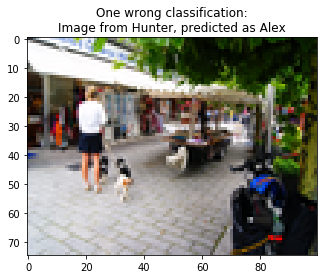

In [16]:
plt.imshow(X_alex_hunter_test[57])
plt.title("One wrong classification:\nImage from Hunter, predicted as Alex")
plt.show()